# Exploring dimensionless numbers and Neural Network Regression
Author: Payam Mousavi  
Last updated: March 11, 2024 

Given the analytical equation (fitted empirically) for the Drag Coefficient $C_D$ provided in reference: https://pages.mtu.edu/~fmorriso/DataCorrelationForSphereDrag2016.pdf, we see that it's only a function of the Reynolds number, $Re = \rho.U.D/\mu$. Let's say that we did not know this ahead of time and wanted to perform experiments for a range of input parameters, namely, $\rho$, $U$, $D$, and $\mu$. Clearly, many combinations will be redundant since they correpond to the same $Re$. Consider the following models:  

Given $\rho$, $U$, $D$, and $\mu$, consider the following Model:  


<img src="./Figures/Model_I.png" width="300" height="200" /> . 
 

In this notebook, we explore the most complicated model that takes as input $\rho$, $U$, $D$, and $\mu$, and outputs $C_D$. However, we assume that we don't know about the usefulness of Re or its functional form. We investigate whether or not creating a bottleneck of size one will allow the model to discover Re.  

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


from utils import *
from models import Model_II, Model_0, Model_I
from datasets import *
from train import train_model
from predict import predict_model
from eval import eval_model

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import torch.nn.init as init
from torch.utils.tensorboard import SummaryWriter

matplotlib.rcParams.update({'font.size': 18})
eps = 1e-12

In [ ]:
# Testing the Model_I Re node monitoring:
model = Model_I()
test_input = torch.rand(1,4)
output, intermediate_output = model(test_input, return_intermediate=True)
print(f"Output: {output}, Intermediate output: {intermediate_output}")


In [ ]:
def plot_CD(Re, CD, marker='o'):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=Re, y=CD, color='blue', marker=marker, alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$Re$')
    plt.ylabel('$C_D$')

In [ ]:
Re_vec = np.logspace(2, 7, 200)
# Re_vec = np.linspace(1e1, 1e7, 1000)
CDs, _ = run_experiments(Re_vec=Re_vec)

Re_vec_rescaled = Re_vec/1e6
plot_CD(Re_vec_rescaled, CDs, marker='o')

## Dataset Creation 

### 4-input dataset:

In [2]:
# Create the dataloader/dataset:
# NOTE: the dataset is scaled to improve the training process
SAMPLING_METHOD = 'naive' # 'naive' or 'uniform-Re'
dataset = RandomDataset_scaled(num_samples=50000,
                               parms_scaling=[1e3, 1e-2, 1, 1],
                               Re_range=[1e3, 1e7],
                               rho_range=[200, 3000],
                               mu_range=[0.6e-2, 1],
                               D_range=[0.5, 1],
                               U_range=[10, 20],
                               sampling_method=SAMPLING_METHOD, # 'naive' or 'uniform-Re'
                               seed=1234)


# Split the dataset into train, validation, and test sets:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# Extract Re values for test set:
train_Re = extract_Re_values(dataset, train_dataset)
val_Re = extract_Re_values(dataset, val_dataset)
test_Re = extract_Re_values(dataset, test_dataset)

test_Re = np.array(test_Re)

In [ ]:
# Verifying that the ranges of the 4 parameters are consistent with the desired range of Re:
rho_range = [200, 3000]
mu_range = [0.6e-2, 1]
D_range = [0.5, 1]
U_range = [10, 20]

min_Re = rho_range[0] * D_range[0] * U_range[0] /mu_range[1]
print(f"{min_Re:0.2e}")

max_Re = rho_range[1] * D_range[1] * U_range[1] /mu_range[0]
print(f"{max_Re:0.2e}")

In [ ]:
plt.hist(test_Re, bins=10, edgecolor='black')
plt.xlabel('Reynolds Number (Re)')
plt.ylabel('Frequency')
plt.title('Histogram of Reynolds Numbers (/1E5) in Test Dataset')
plt.savefig('Figures/Model_II-Re_histogram.png')
plt.show()

# min(test_Re), max(test_Re)

# Training

### Model_I:  
Note that there is an additional optional parameter added to the model to read off the value of the node with size 1. This is expected to be the actual Re if this is discovered during training.  

In [5]:
# Setting up the model:
HIDDEN_DIMS = [32, 16, 8, 4, 1, 64, 32, 16, 8, 4] # Note that hidden layer with dimension 1 is (we hope) the Re layer
# HIDDEN_DIMS = [64, 32, 16, 8, 4] # Note that hidden layer with dimension 1 is (we hope) the Re layer

MODEL_NAME = 'Model_I'
MODEL = Model_I(input_dim=4, output_dim=1, hidden_dims=HIDDEN_DIMS).float()
CRITERION = nn.MSELoss() # criterion = nn.L1Loss(), nn.SmoothL1Loss(), ...
OPTIMIZER = Adam(MODEL.parameters(), lr=1e-3)
WRITER = SummaryWriter('runs/' + MODEL_NAME)
MODEL_SAVE_PATH = 'models/' + MODEL_NAME + '.pt'
WRITER_PATH = 'runs/' + MODEL_NAME

NUM_EPOCHS = 50

num_trainable_params = sum(p.numel() for p in MODEL.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 3778


In [6]:
best_model_state, history = train_model(model=MODEL, 
                                        train_loader=train_loader, 
                                        val_loader=val_loader, 
                                        test_loader=test_loader, 
                                        optimizer=OPTIMIZER, 
                                        criterion=CRITERION, 
                                        num_epochs=NUM_EPOCHS, 
                                        model_save_path=MODEL_SAVE_PATH,
                                        writer_path=WRITER_PATH)

Epoch 1/50, Train Loss: 0.0170, Validation Loss: 0.0089
Epoch 2/50, Train Loss: 0.0071, Validation Loss: 0.0055
Epoch 3/50, Train Loss: 0.0038, Validation Loss: 0.0026
Epoch 4/50, Train Loss: 0.0020, Validation Loss: 0.0015
Epoch 5/50, Train Loss: 0.0012, Validation Loss: 0.0010
Epoch 6/50, Train Loss: 0.0008, Validation Loss: 0.0007
Epoch 7/50, Train Loss: 0.0007, Validation Loss: 0.0006
Epoch 8/50, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 9/50, Train Loss: 0.0005, Validation Loss: 0.0005
Epoch 10/50, Train Loss: 0.0005, Validation Loss: 0.0005
Epoch 11/50, Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 12/50, Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 13/50, Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 14/50, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 15/50, Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 16/50, Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 17/50, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 18/50, Train Loss: 0.0003, Validat

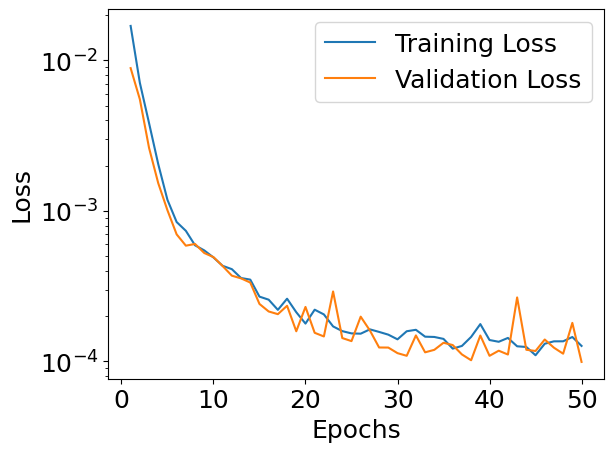

In [7]:
# plot the training and validation loss
figure_path = 'Figures/' + MODEL_NAME + '_' + SAMPLING_METHOD + '-loss.png'
epochs = range(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.show()

# save history as a pickel file:
history_path = 'History/' + MODEL_NAME + '_' + SAMPLING_METHOD + '-history.pkl'
with open(history_path, 'wb') as f:
    pkl.dump(history, f)

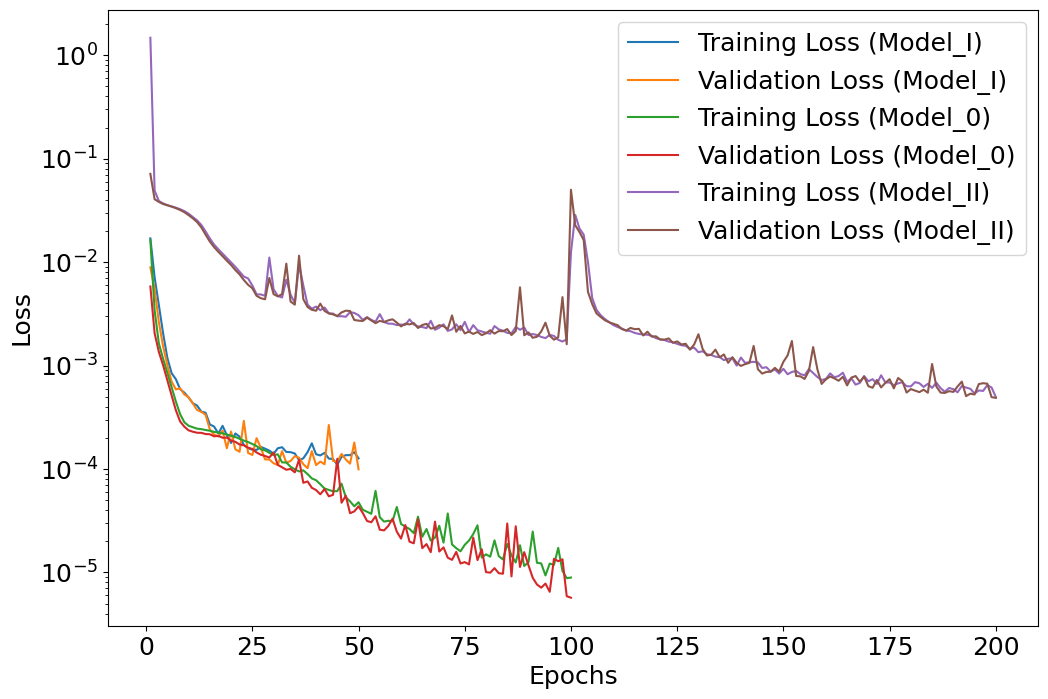

In [13]:
# Load and plot Model_0 training curves for comparison:
history_path = 'History/Model_0-history.pkl'
with open(history_path, 'rb') as f:
    history_0 = pkl.load(f)

# Load and plot Model_0 training curves for comparison:
history_path = 'History/Model_II-history.pkl'
with open(history_path, 'rb') as f:
    history_2 = pkl.load(f)

figure_path = 'Figures/' + MODEL_NAME + '-loss.png'
epochs = range(1, len(history['train_loss']) + 1)
epochs_0 = range(1, len(history_0['train_loss']) + 1)
epochs_2 = range(1, len(history_2['train_loss']) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, history['train_loss'], label='Training Loss (Model_I)')
plt.plot(epochs, history['val_loss'], label='Validation Loss (Model_I)')
plt.plot(epochs_0, history_0['train_loss'], label='Training Loss (Model_0)')
plt.plot(epochs_0, history_0['val_loss'], label='Validation Loss (Model_0)')
plt.plot(epochs_2, history_2['train_loss'], label='Training Loss (Model_II)')
plt.plot(epochs_2, history_2['val_loss'], label='Validation Loss (Model_II)')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
figure_path = 'Figures/Model_0_I_II-loss-comparison.png'
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.show()

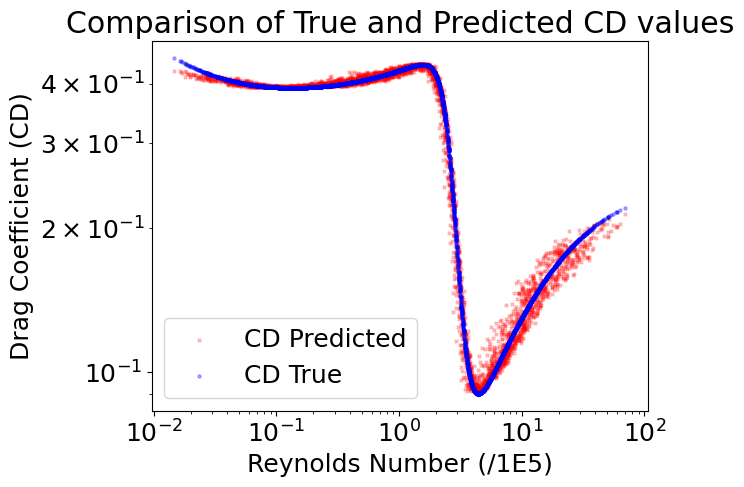

MSE: 0.00011, MAE: 0.00576


In [10]:
# Prediction:
DATASET_TEST = test_dataset
MODEL_SAVE_PATH = 'models/' + MODEL_NAME + '.pt'
predictions = predict_model(model_path=MODEL_SAVE_PATH, 
                            dataset=DATASET_TEST)

# Evaluation:
mse, mae = eval_model(DATASET_TEST, MODEL_SAVE_PATH, visualize=True)
print(f"MSE: {mse:.5f}, MAE: {mae:.5f}")


Correlation coefficient: -0.900


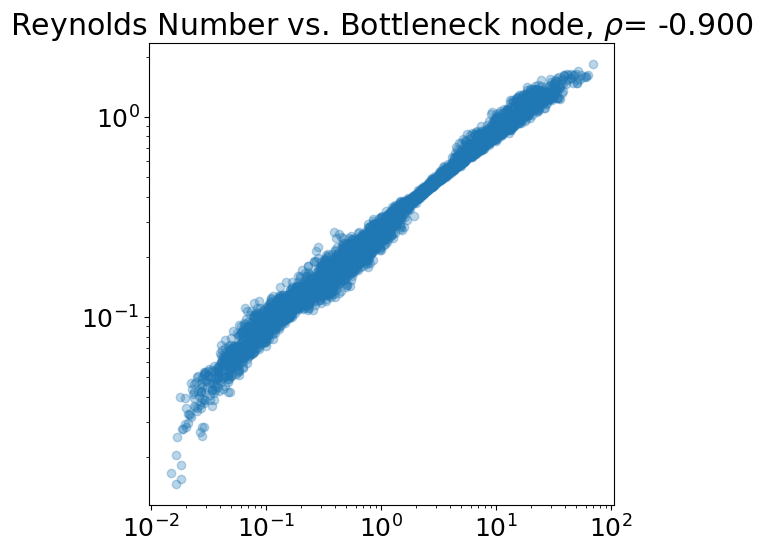

In [27]:
# Let's check the intermediate parameter: Is it the Reynolds number?
# Prediction:
DATASET_TEST = test_dataset
MODEL_SAVE_PATH = 'models/' + MODEL_NAME + '.pt'
predictions, re_node = predict_model(model_path=MODEL_SAVE_PATH,
                                     dataset=DATASET_TEST,
                                     return_intermediate=True)

Re_vec = []
for idx in DATASET_TEST.indices:
    Re_vec.append(DATASET_TEST.dataset.Re[idx])
Re_vec = np.array(Re_vec)

corr_coef = np.corrcoef(Re_vec, re_node)
print(f"Correlation coefficient: {corr_coef[0,1]:0.3f}")

plt.figure(figsize=(6, 6))
plt.plot(np.abs(Re_vec), np.abs(re_node), 'o', alpha=0.3)
plt.title(f"Reynolds Number vs. Bottleneck node, $\\rho$= {corr_coef[0,1]:.3f}")
plt.xscale('log')
plt.yscale('log')
plt.savefig('Figures/Model_I-Re_node-correlation.png')



In [ ]:
# Test out the dataset to make sure it makes sense

Re_list = []
CD_list = []

# Scaling factors
parms_scaling = [1e3, 1e-2, 1, 1]

# Iterate through the train_dataset
for input_sample, target in train_dataset:
    # Re-scale the input parameters
    rho = input_sample[0] * parms_scaling[0]
    mu = input_sample[1] * parms_scaling[1]
    D = input_sample[2] * parms_scaling[2]
    U = input_sample[3] * parms_scaling[3]
    
    # Calculate Re using the re-scaled parameters
    Re = rho * D * U / mu
    CD = target.item()
    Re_list.append(Re)
    CD_list.append(CD)

# Create a log-log plot of CD vs. Re
plt.figure(figsize=(8, 6))
plt.loglog(Re_list, CD_list, 'o', markersize=2)
plt.xlabel('Re')
plt.ylabel('CD')
plt.title('CD vs. Re (Train Dataset)')
plt.grid(True)
plt.show()

## Inference & Testing:  
Visualize the model fit by looking at the curves for a regularly-spaced Re vector covering the entire range.

In [ ]:
def infer_cd_from_re(re_vector, model_path, hidden_dims = HIDDEN_DIMS, inputs=None):
    # HIDDEN_DIMS = [256, 256, 64, 32] #TODO: add this as a parameter to this function
    model = Model_II(input_dim=4, output_dim=1, hidden_dims=[256, 128, 64, 32, 32, 32, 16, 8, 4])
    model_checkpoint = torch.load(model_path)
    model.load_state_dict(model_checkpoint)
    model.eval()

    # Check if inputs are provided or need to be generated
    if inputs is None:
        # Generate inputs from Re vector
        rho, mu, D, U = generate_inputs_from_Re(Re_vec=re_vector,  # Corrected variable name
                                                u_range=[0.01, 20],
                                                rho_range=[10, 2000],
                                                mu_range=[1e-3, 0.1],
                                                D_range=[0.05, 0.5])
        input_tensor = torch.tensor(np.column_stack((rho, mu, D, U)), dtype=torch.float32)
    else:
        test_inputs = []
        for idx in range(len(inputs)):
            input_sample, _ = inputs[idx]  # Get the input sample and ignore the target
            test_inputs.append(input_sample)  # Convert to numpy if it's a tensor

        # Convert list to numpy array and then to tensor
        input_tensor = torch.tensor(np.stack(test_inputs), dtype=torch.float32)

    # Perform inference
    with torch.no_grad():
        cd_predicted = model(input_tensor).squeeze().numpy()

    return cd_predicted



### Method #1:

In [ ]:
rho, mu, D, U, Re_vec, CD = sample_parameters_naive(num_samples=5000,
                                              Re_range=None,
                                              rho_range=[10, 2000],
                                              mu_range=[0.001, 0.1],
                                              D_range=[0.05, 0.5],
                                              U_range=[0.01, 20])

cd_predicted = infer_cd_from_re(re_vector=Re_vec, model_path='models/Model-II-checkpoint.pth')
cd_true = CD

plt.figure(figsize=(10, 6))

plt.scatter(Re_vec, cd_predicted, color='red',
            label='CD Predicted', marker='x')
plt.scatter(Re_vec, cd_true, color='blue', label='CD True', marker='o')
plt.xscale('log')
plt.yscale('log')


plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient (CD)')
plt.title('Comparison of True and Predicted CD values')
plt.legend()
plt.show()

mse_error = np.mean((cd_true - cd_predicted)**2)
print("MSE:", mse_error)

In [ ]:
Re_vec[0:10]

### Method #2:

In [ ]:
# Testing:
# Generate a random Re vector:
Re_vec = np.array(train_Re) #np.logspace(2, 7, 200)
# Re_vec = np.logspace(-1, 11, 5000)
# Infer the CD from the Re vector:
cd_predicted = infer_cd_from_re(Re_vec, model_path='models/Model-II-checkpoint.pth', inputs=train_dataset)
cd_true, _ = run_experiments(Re_vec=Re_vec)

plt.figure(figsize=(10, 6))

# Plotting predicted CD values
plt.scatter(Re_vec, cd_predicted, color='red', label='CD Predicted', marker='x', alpha=0.5)
plt.scatter(Re_vec, cd_true, color='blue', label='CD True', marker='o', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient (CD)')
plt.title('Comparison of True and Predicted CD values')
plt.legend()
plt.show()


mse_error = np.mean((cd_true - cd_predicted)**2)
print("MSE:", mse_error)
r2 = 1 - np.sum((cd_true - cd_predicted)**2) / np.sum((cd_true - np.mean(cd_true))**2)
print("R2:", r2)


plt.hist(Re_vec, bins=10, edgecolor='black')
plt.xlabel('Reynolds Number (Re)')
plt.ylabel('Frequency')
plt.title('Histogram of Reynolds Numbers in Test Dataset')
plt.show()


In [ ]:
min(Re_vec)